In [1]:
import torch # facebook에서 제공하는 딥러닝 도구로서, numpy와 효율적인 연동을 지원하는 편리한 도구이다
import torch.nn as nn  # 신경망을 생성할 수 있는 패키지
import torch.nn.functional as F  # torch.nn.functional로 구현한 함수의 경우에는 인스턴스화 시킬 필요 없이 사용이 가능(nn과의 차이)
import torch.optim as optim # 다양한 optimization 알고리즘을 구현한 패키지
import torchvision # PyTorch와 함께 사용되는 Computer Vision 용 라이브러리
import torchvision.transforms as transforms # common image transformations
#torch.utils.data.DataLoader : 데이터를 파이썬 iterable로써 접근할 수 있게 해주는 클래스
#torch.utils.data Dataset : 데이터셋을 나타내는 추상클래스
from torch.utils.data import Dataset, DataLoader # 
import timm # 유명한 네트워크 불러오는 라이브러리(현재사용하고 있는 네트워크도 이것으로 불러옴) (수업때는 torch hub에서 불러왔었음)
import argparse # 프로그램에 필요한 인자를 사용자 친화적인 명령행 인터페이스로 쉽게 작성하도록 돕는 라이브러리

import os #운영체제와의 상호작용을 돕는 다양한 기능을 제공하는 모듈
import numpy as np # Matrix와 vector와 같은 Array 연산을 할 때 사용하는 라이브러리
import matplotlib.pyplot as plt #다양한 데이터를 많은 방법으로 도식화 할 수 있도록 하는 파이썬 라이브러리
from PIL import Image #이미지 처리와 그래픽기능 제공하는 라이브러리 (픽셀 단위의 조작,마스킹,투명도 제어,이미지 필터)
import cv2 # # openCV 사용할때는 cv2로 import함
#OpenCV : Open Source Computer Vision의 약자로 다양한 영상/동영상 처리에 사용할 수 있는 오픈소스 라이브러리입니다. 
import skimage.transform 
# 
import scipy.ndimage as nd #Open Source Computer Vision의 약자로 다양한 영상/동영상 처리에 사용할 수 있는 오픈소스 라이브러리입니다. 
import scipy.ndimage.morphology as mp # 이 패키지에는 multidimensional image를 위한 다양한 function이 포함되어 있음.
import random # 파이썬에서 난수(random number)를 구할 수 있는 모듈
import time #시간과 날짜를 다루기 위한 모듈
from tqdm import tqdm # 즉석에서 progress bar를 생성해주고 함수나 반복문의 TTC (Time To Completion) 를 예측하는 파이썬


In [ ]:
!pip install torch
!pip install torchvision
!pip install timm
!pip install opencv-python

In [2]:
parser = argparse.ArgumentParser(description = "step1 Cancer Segmentation EfficientNet-b0") # 객체선언(argparse.ArgumentParser)
parser.add_argument('--batch_size', default = 100, type = int, help='batch size') # 클레스에 대한 멤버변수 사용(batch_size)
parser.add_argument('--num_epochs', default = 50, type = int, help='training epochs') # 클레스에 대한 멤버변수 사용(epochs)
parser.add_argument('--lr', default = 0.02, type = float, help = 'learning rate') # 클레스에 대한 멤버변수 사용(learning rate)
parser.add_argument('--num_workers', type = int, default = 6) # 클레스에 대한 멤버변수 사용(학습도중 몇 개의 코어사용할건지)
parser.add_argument('--level', type = int, default = 1) # 클레스에 대한 멤버변수 사용(level)
parser.add_argument('--valid_s', type = int, default = 36) # 클레스에 대한 멤버변수 사용(???)
parser.add_argument('--valid_e', type = int, default = 41) # 클레스에 대한 멤버변수 사용(???)
parser.add_argument('--resume', default = False) # 클레스에 대한 멤버변수 사용(resume 할지??)
parser.add_argument('--resume_epoch', type = int, default = 0) # 클레스에 대한 멤버변수 사용(resume epoch??)

#args = parser.parse_args() ###여기서 에러남

root_dir = 'Y:\\data\\patch\\train'
batch_size = 100      # batch size
lr = 3e-4  # learning rate
num_epochs = 50       # epochs
num_workers = 6       # 학습 도중 CPU의 작업을 몇 개의 코어를 사용해서 진행할지에 대한 설정 파라미터
level = 3             # level
valid_s = 36          # ?? start 
valid_e = 41          # ??  end
resume = False        # 재개?
resume_epoch = 0      # 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # # GPU 사용하기 위해 설정



In [3]:
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    random.seed(seed_value)
    if use_cuda:
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False
seed = 42
random_seed(seed, True)

In [4]:
# 경로를 다 가져오는 과정

def path_list(root_dir, mode, valid_num, level): # 작업을 수행할 데이터들의 경로를 하나의 리스트에 담기 위한 함수??
    data_list = []          # data list 생성
    num = 0
    level_dim = str(level)   # level에 대한 정보를 담고 있는 변수??
    meta_labels = ["NOLN_metastasis", "LN_metastasis"] # NOLN인지 LN인지에 대한 label
    cancer_labels = ["normal", "cancer"] # normal인지 cancer인지에 대한 label
    
    for meta_label in sorted(os.listdir(os.path.join(root_dir))): # root_dir디렉토리 내의 [모든 파일과 디렉토리의 폴더명] 리스트를 리턴한다
        if meta_label not in meta_labels: #NOLN 과 LN 둘다 아니라면
            continue # 그다음 실행
        for patient in sorted(os.listdir(os.path.join(root_dir, meta_label))): #NOLN과 LN중 하나면 root_dir과 경로합쳐서 모든 파일과 디렉토리의 폴더명의 리스트를 반환
            if mode == 'train': #mode가 train이면
                if 'LN' not in patient: # LN이 patient에 없다면 (NOLN, LN 둘 다 아닌 경우)
                    continue # 다음 반복문
                if patient.split('_')[-1] in valid_num: #patient를 나타내는 글자와 _로구분되어 있는 글자가 valid_num (036~040)에 해당하면
                    continue # 다음 반복문
                else:   #LN이 patient에 있고 valid_num에 해당하지 않으면
                    for cancer_label in sorted(os.listdir(os.path.join(root_dir, meta_label, patient, level_dim))): #rootdir, LN인지 NOLN인지, 환자 번호, level차원에 해당하는 정보들을 담고 있는 디렉토리명 경로를 모두 하나로 합쳐서 각각 하나의 경로로만듬  
                        if cancer_label not in cancer_labels: # 만약 위에서 하나씩 가져온 경로중 normal이나 cancer에 대한 것이 없다면
                            continue # 다음 반복문
                        if cancer_label == 'normal': #cancer_label이 normal이면 label_value변수에 0넣음(normal은 0으로 labeling?)
                            label_value = 0
                        elif cancer_label == 'cancer': #cancer_label이 cancer면 (caner는 1로 labeling)
                            label_value = 1
                        for image in sorted(os.listdir(os.path.join(root_dir, meta_label, patient, level_dim, cancer_label, "img"))):
                            if image.split('.')[-1] != 'png': # img 내에 있는 파일 중 (패치 파일) png가 아니라면
                                continue #다음 반복문
                            else: # png라면 case라는 딕셔너리 생성하여 imge와 label 쌍으로 만듬
                                case = { 
                                    'image' : os.path.join(root_dir, meta_label, patient, level_dim, cancer_label, "img", image),
                                    'label' : label_value
                                }
                                data_list.append(case) # 이렇게 생성된 하나의 딕셔너리를 data_list 원소로 추가
            else: # mode가 train이 아니면
                if patient.split('_')[-1] in valid_num: # patient를 나타내는 글자와 _로구분되어 있는 글자가 valid_num에 해당하면
                    for cancer_label in sorted(os.listdir(os.path.join(root_dir, meta_label, patient, level_dim))): # 만약 위에서 하나씩 가져온 경로중 normal이나 cancer에 대한 것이 없다면
                        if cancer_label not in cancer_labels: # 만약 위에서 하나씩 가져온 경로중 normal이나 cancer에 대한 것이 없다면
                            continue #다음 반복문으로
                        if cancer_label == 'normal': # cancer_label이 normal이면 label_value변수에 0넣음(normal은 0으로 labeling?)
                            label_value = 0          
                        elif cancer_label == 'cancer': # cancer_label이 cancer면 (caner는 1로 labeling)
                            label_value = 1
                        for image in sorted(os.listdir(os.path.join(root_dir, meta_label, patient, level_dim, cancer_label, "img"))):
                            if image.split('.')[-1] != 'png': # img 내에 있는 파일 중 (패치 파일) png가 아니라면
                                continue # 다음 반복문
                            else:  # png라면 case라는 딕셔너리 생성하여 imge와 label 쌍으로 만듬
                                case = {
                                    'image' : os.path.join(root_dir, meta_label, patient, level_dim, cancer_label, "img", image),
                                    'label' : label_value
                                }
                                data_list.append(case) # 이렇게 생성된 하나의 딕셔너리를 data_list 원소로 추가
    return data_list


In [5]:
start = time.perf_counter() # 코드에 실행시간 측정하는 함수
valid_num = list() # valid_num이라는 빈 리스트 생성
for i in range(valid_s,valid_e): # valid_s 부터 valid_e까지 반복문 실행
    val_num = format(i, '03') # val_num에 i라는 수를 세글자가 되도록 formating
    valid_num.append(val_num) # val_num을 valid_num이라는 리스트에 추가
train_list = path_list(root_dir, "train", valid_num, level) # train data에 대한 경로들이 담긴 list를 train_list에 저장??
valid_list = path_list(root_dir, "valid", valid_num, level) # valid data에 대한 경로들이 담긴 list를 valid_list에 저장??
print(f"training Level : {level}")  #
print('* Time: %.3f' %(time.perf_counter() - start)) #코드실행시간 하는 데 걸린 시간
print(f"train_list : {len(train_list)}, valid_list : {len(valid_list)}") #

# data\\patch\\train\\
# trainset LN : 35명 NOLN : 35명
# validset LN : 5명  NOLN : 5명

training Level : 3
* Time: 24.663
train_list : 259460, valid_list : 37708


In [ ]:
a = os.listdir(os.path.join(root_dir,"LN_metastasis"))
print(a)

In [ ]:
for i in range(10):
    print(train_list[i])
    print(train_list[1972])
    

In [ ]:
i = 4
kim = format(i,'03')
print(kim)

In [6]:
# Data loader 공부할 것
#
class MyDataset(Dataset): # Data loader에 대한 클래스
    def __init__(self, path_list, transform = None): # 생성자 함수
        self.path_list = path_list  # data들에 경로가 담긴 list 에 대한 멤버변수?           
        self.transform = transform  # 어떤 transform인가에 대한 멤버변수?? 
        
    def __getitem__(self, index): # 이미지 하나를 불러와서 전처리하고 이미지와 label정보가 담긴 딕셔너리 형태로 반환하는 멤버함수? 
        image = Image.open(self.path_list[index]['image']) # data 경로 리스트 중 하나의 이미지 파일을 열기 
        image = image.convert("RGB") # 그 이미지를 RGB채널로 바꾸기
        label = torch.tensor(self.path_list[index]['label'] ).type(torch.uint8) #딥러닝에 사용할 때 label을 tensor 형태로 바꿔줘야함
        
        if self.transform: # 만약 transform이 True면
            image = self.transform(image) #이미지에 transfomr적용함
        data = {'image' : image, 'label' : label.item()} # 이미지와 label에 대한 정보가 딕셔너리형태로 data에 저장돰

        return data # 딕셔너리 형태의 image와 그 이미지의 label 정보를 반환

    def __len__(self):  # 총 데이터가 몇 개 있는지 출력해주는 함수 ??
        return len(self.path_list)

In [7]:
# 학습과정중 overffiting 방지하기 위해 trainset에 data들을 여러가지 transform 기법으로 변환
tra = [              
    transforms.RandomHorizontalFlip(), # 수평Flip
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3), #brightness, contrast 등을 변화시킨다 
    transforms.RandomAffine((-10,10), shear=10, scale=(0.9, 1.2)), #affain transform적용 shear과 sclaing
    transforms.RandomRotation(90), # random rotation
#     transforms.Resize((224,224)), # resize
    transforms.ToTensor(), #데이터타입을 tensor로 변경
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 노말라이즈변환
    ]

val = [  #valid set에 있는 데이터 들에 대해서도 데이터 타입 tensor로 바꾸고 Nomarlize함
#     transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]

trainset = MyDataset(train_list, transform = transforms.Compose(tra)) #변환 적용한 train set에 대한 객체 생성
validset = MyDataset(valid_list, transform = transforms.Compose(val)) #변환 적용한 valid set에 대한 객체 생성
for i in range(10):
    print(trainset.path_list[i])

# In[9]:

#num_workers = num_workers

# train data에 대한 data_loader 정의
train_loader = torch.utils.data.DataLoader(trainset,batch_size=batch_size, shuffle = True, pin_memory = True)
# valid data에 대한 data_loader 정의
valid_loader = torch.utils.data.DataLoader(validset,batch_size=batch_size, shuffle = False, pin_memory = True)






#z=0
#for bc,dat in enumerate(train_loader):
#    x, y = dat
#    print(x)
#    print(y)
#    break
#    z += 1
#    if z == 4: break

#for batch_idx, data in enumerate(train_loader):
#    print(type(data))
#    print(data)
#    x, y = data.items()
#    print(x)
#   print(y)
#    break






# 네트워크 
net = timm.create_model("tf_efficientnet_b0_ns", pretrained = True, num_classes = 2)
net = net.to(device) #gpu사용 가능하면 사용

# loss function 정의
loss = torch.nn.CrossEntropyLoss() # loss

# ooptimizer
alg = torch.optim.SGD(net.parameters(),lr=lr)

#train_features, train_labels = next(iter(train_loader))
#print(f"Feature batch shape: {train_features.size()}")
#print(f"Labels batch shape: {train_labels.size()}")

{'image': 'Y:\\data\\patch\\train\\LN_metastasis\\LN_001\\3\\cancer\\img\\LN_001_00000.png', 'label': 1}
{'image': 'Y:\\data\\patch\\train\\LN_metastasis\\LN_001\\3\\cancer\\img\\LN_001_00001.png', 'label': 1}
{'image': 'Y:\\data\\patch\\train\\LN_metastasis\\LN_001\\3\\cancer\\img\\LN_001_00002.png', 'label': 1}
{'image': 'Y:\\data\\patch\\train\\LN_metastasis\\LN_001\\3\\cancer\\img\\LN_001_00003.png', 'label': 1}
{'image': 'Y:\\data\\patch\\train\\LN_metastasis\\LN_001\\3\\cancer\\img\\LN_001_00004.png', 'label': 1}
{'image': 'Y:\\data\\patch\\train\\LN_metastasis\\LN_001\\3\\cancer\\img\\LN_001_00005.png', 'label': 1}
{'image': 'Y:\\data\\patch\\train\\LN_metastasis\\LN_001\\3\\cancer\\img\\LN_001_00006.png', 'label': 1}
{'image': 'Y:\\data\\patch\\train\\LN_metastasis\\LN_001\\3\\cancer\\img\\LN_001_00007.png', 'label': 1}
{'image': 'Y:\\data\\patch\\train\\LN_metastasis\\LN_001\\3\\cancer\\img\\LN_001_00008.png', 'label': 1}
{'image': 'Y:\\data\\patch\\train\\LN_metastasis\\LN_00

In [ ]:
c = {'a' : 123, 'b': 456}
g,h = c.items()
print(g)
print(h)

In [ ]:
print(type(train_loader))
print(train_loader)
One_batch = next(iter(train_loader))
for i in One_batch:
    print(i)
    break;

print('끝')

In [ ]:
print(trainset.path_list[0])
print(train_loader[0])
images = next(iter(train_loader))
print(images.size())

학습!!

2595it [1:34:13,  2.18s/it]
<ipython-input-8-012b4a5e8e94>:45: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accs_train = np.append(accs_train,correct.cpu()/np.float(len(trainset))) # loss_train array에 해당 epoch의 평균 accuracy값 추가??print('2')
0it [00:00, ?it/s]

2


378it [07:28,  1.19s/it]
<ipython-input-8-012b4a5e8e94>:65: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accs_valid = np.append(accs_valid,correct.cpu()/np.float(len(validset))) # loss_train array에 해당 epoch의 평균 accuracy값 추가??
<ipython-input-8-012b4a5e8e94>:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (correct.cpu()/np.float(len(v

3
saved new best metric model


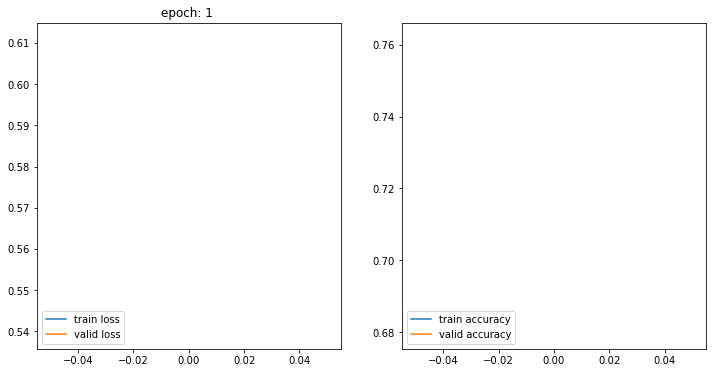

train loss:  0.6113173997471099
valid loss:  0.5393537087415261
train accuracy:  0.6795228719711304
valid accuracy:  0.7620133757591248
best metric epoch : 0, best metric accuracy : 0.7620133757591248
1 epoch time : 101.73032318353653 min


2595it [1:10:05,  1.62s/it]
<ipython-input-8-012b4a5e8e94>:45: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accs_train = np.append(accs_train,correct.cpu()/np.float(len(trainset))) # loss_train array에 해당 epoch의 평균 accuracy값 추가??print('2')
0it [00:00, ?it/s]

2


378it [06:55,  1.10s/it]
<ipython-input-8-012b4a5e8e94>:65: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accs_valid = np.append(accs_valid,correct.cpu()/np.float(len(validset))) # loss_train array에 해당 epoch의 평균 accuracy값 추가??
<ipython-input-8-012b4a5e8e94>:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (correct.cpu()/np.float(len(v

3
saved new best metric model


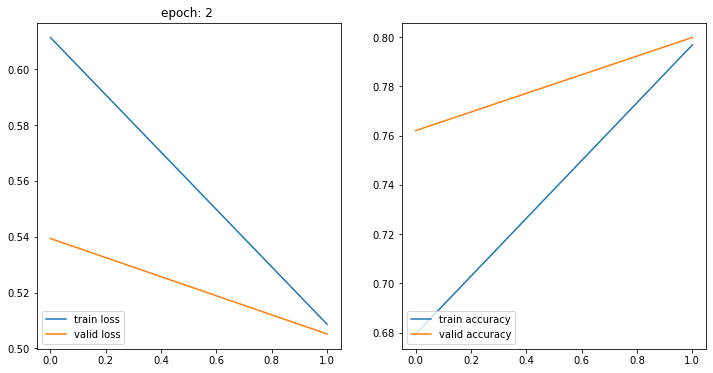

0it [00:00, ?it/s]

train loss:  0.5086592775319123
valid loss:  0.505176443271536
train accuracy:  0.7967933416366577
valid accuracy:  0.7998037338256836
best metric epoch : 1, best metric accuracy : 0.7998037338256836
1 epoch time : 77.03542118469873 min


2595it [1:09:45,  1.61s/it]
<ipython-input-8-012b4a5e8e94>:45: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accs_train = np.append(accs_train,correct.cpu()/np.float(len(trainset))) # loss_train array에 해당 epoch의 평균 accuracy값 추가??print('2')
0it [00:00, ?it/s]

2


378it [07:02,  1.12s/it]
<ipython-input-8-012b4a5e8e94>:65: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accs_valid = np.append(accs_valid,correct.cpu()/np.float(len(validset))) # loss_train array에 해당 epoch의 평균 accuracy값 추가??
<ipython-input-8-012b4a5e8e94>:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (correct.cpu()/np.float(len(v

3
saved new best metric model


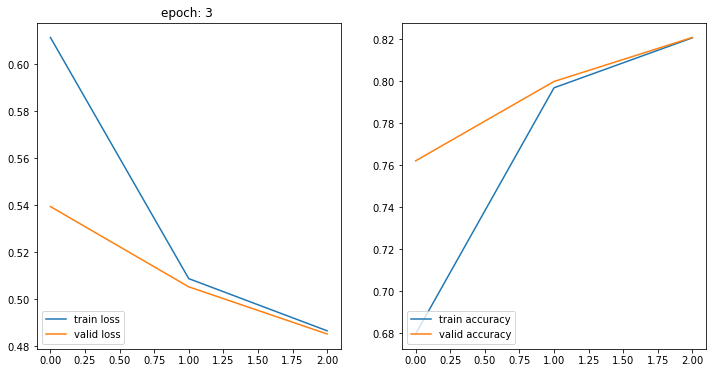

train loss:  0.48646190841763004
valid loss:  0.48510746224216683
train accuracy:  0.8206081986427307
valid accuracy:  0.8207807540893555
best metric epoch : 2, best metric accuracy : 0.8207807540893555
1 epoch time : 76.83567282358806 min


2595it [1:09:03,  1.60s/it]
<ipython-input-8-012b4a5e8e94>:45: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accs_train = np.append(accs_train,correct.cpu()/np.float(len(trainset))) # loss_train array에 해당 epoch의 평균 accuracy값 추가??print('2')
0it [00:00, ?it/s]

2


378it [07:14,  1.15s/it]
<ipython-input-8-012b4a5e8e94>:65: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accs_valid = np.append(accs_valid,correct.cpu()/np.float(len(validset))) # loss_train array에 해당 epoch의 평균 accuracy값 추가??
<ipython-input-8-012b4a5e8e94>:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (correct.cpu()/np.float(len(v

3
saved new best metric model


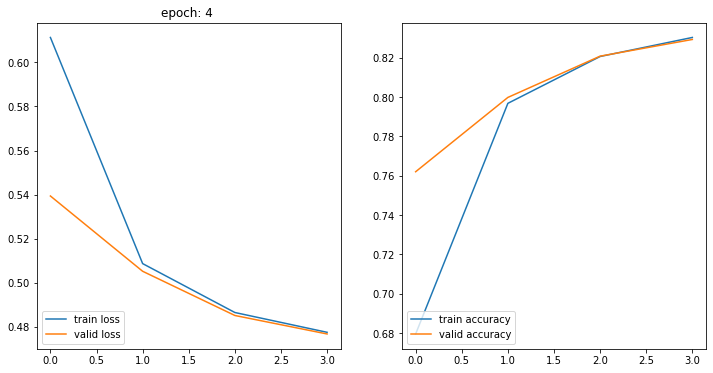

train loss:  0.4774664788806599
valid loss:  0.47671512825779183
train accuracy:  0.8302859663963318
valid accuracy:  0.8292670249938965
best metric epoch : 3, best metric accuracy : 0.8292670249938965
1 epoch time : 76.32198175986608 min


2595it [1:12:09,  1.67s/it]
<ipython-input-8-012b4a5e8e94>:45: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accs_train = np.append(accs_train,correct.cpu()/np.float(len(trainset))) # loss_train array에 해당 epoch의 평균 accuracy값 추가??print('2')
0it [00:00, ?it/s]

2


378it [09:29,  1.51s/it]
<ipython-input-8-012b4a5e8e94>:65: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accs_valid = np.append(accs_valid,correct.cpu()/np.float(len(validset))) # loss_train array에 해당 epoch의 평균 accuracy값 추가??
<ipython-input-8-012b4a5e8e94>:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (correct.cpu()/np.float(len(v

3
saved new best metric model


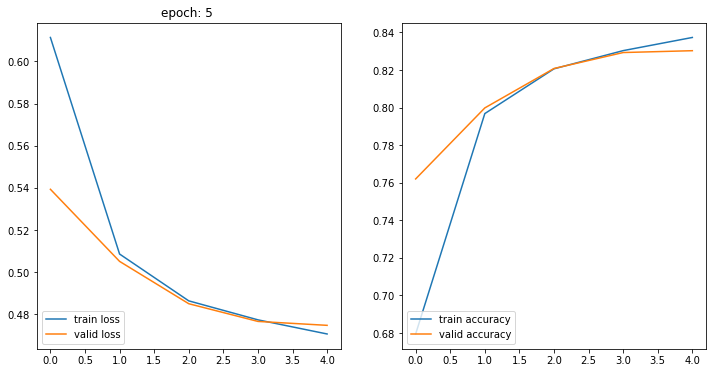

train loss:  0.4707666297868497
valid loss:  0.47485944959852433
train accuracy:  0.8372889757156372
valid accuracy:  0.830248236656189
best metric epoch : 4, best metric accuracy : 0.830248236656189
1 epoch time : 81.6726697921753 min


2595it [1:29:42,  2.07s/it]
<ipython-input-8-012b4a5e8e94>:45: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accs_train = np.append(accs_train,correct.cpu()/np.float(len(trainset))) # loss_train array에 해당 epoch의 평균 accuracy값 추가??print('2')
0it [00:00, ?it/s]

2


378it [10:05,  1.60s/it]
<ipython-input-8-012b4a5e8e94>:65: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accs_valid = np.append(accs_valid,correct.cpu()/np.float(len(validset))) # loss_train array에 해당 epoch의 평균 accuracy값 추가??
<ipython-input-8-012b4a5e8e94>:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (correct.cpu()/np.float(len(v

3
saved new best metric model


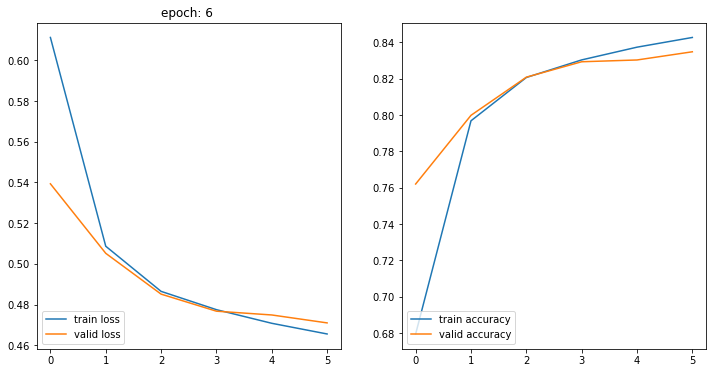

train loss:  0.46551257300698456
valid loss:  0.4709601427512194
train accuracy:  0.8426308631896973
valid accuracy:  0.8347565531730652
best metric epoch : 5, best metric accuracy : 0.8347565531730652
1 epoch time : 99.8268530925115 min


2595it [1:31:15,  2.11s/it]
<ipython-input-8-012b4a5e8e94>:45: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accs_train = np.append(accs_train,correct.cpu()/np.float(len(trainset))) # loss_train array에 해당 epoch의 평균 accuracy값 추가??print('2')
0it [00:00, ?it/s]

2


378it [10:07,  1.61s/it]
<ipython-input-8-012b4a5e8e94>:65: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accs_valid = np.append(accs_valid,correct.cpu()/np.float(len(validset))) # loss_train array에 해당 epoch의 평균 accuracy값 추가??
<ipython-input-8-012b4a5e8e94>:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (correct.cpu()/np.float(len(v

3
saved new best metric model


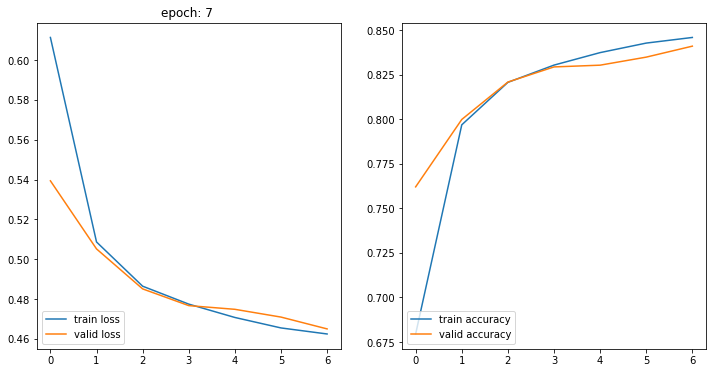

train loss:  0.46248137192919075
valid loss:  0.4650256040865782
train accuracy:  0.845783531665802
valid accuracy:  0.8409090638160706
best metric epoch : 6, best metric accuracy : 0.8409090638160706
1 epoch time : 101.42008210023245 min


2595it [1:29:19,  2.07s/it]
<ipython-input-8-012b4a5e8e94>:45: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accs_train = np.append(accs_train,correct.cpu()/np.float(len(trainset))) # loss_train array에 해당 epoch의 평균 accuracy값 추가??print('2')
0it [00:00, ?it/s]

2


378it [07:44,  1.23s/it]
<ipython-input-8-012b4a5e8e94>:65: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accs_valid = np.append(accs_valid,correct.cpu()/np.float(len(validset))) # loss_train array에 해당 epoch의 평균 accuracy값 추가??
<ipython-input-8-012b4a5e8e94>:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (correct.cpu()/np.float(len(v

3
saved new best metric model


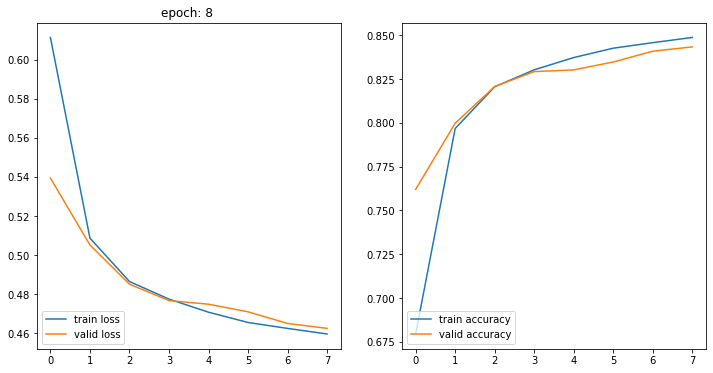

train loss:  0.45963066556779864
valid loss:  0.4625010414729043
train accuracy:  0.8487512469291687
valid accuracy:  0.8433753848075867
best metric epoch : 7, best metric accuracy : 0.8433753848075867
1 epoch time : 97.0903804341952 min


2595it [1:11:44,  1.66s/it]
<ipython-input-8-012b4a5e8e94>:45: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accs_train = np.append(accs_train,correct.cpu()/np.float(len(trainset))) # loss_train array에 해당 epoch의 평균 accuracy값 추가??print('2')
0it [00:00, ?it/s]

2


378it [07:42,  1.22s/it]
<ipython-input-8-012b4a5e8e94>:65: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accs_valid = np.append(accs_valid,correct.cpu()/np.float(len(validset))) # loss_train array에 해당 epoch의 평균 accuracy값 추가??
<ipython-input-8-012b4a5e8e94>:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (correct.cpu()/np.float(len(v

3
saved new best metric model


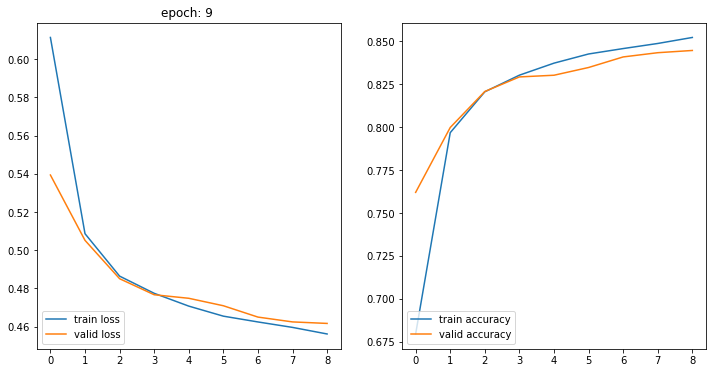

train loss:  0.4561895998916185
valid loss:  0.4617089972924934
train accuracy:  0.8522508144378662
valid accuracy:  0.8446748852729797
best metric epoch : 8, best metric accuracy : 0.8446748852729797
1 epoch time : 79.46819443305334 min


2595it [1:12:22,  1.67s/it]
<ipython-input-8-012b4a5e8e94>:45: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accs_train = np.append(accs_train,correct.cpu()/np.float(len(trainset))) # loss_train array에 해당 epoch의 평균 accuracy값 추가??print('2')
0it [00:00, ?it/s]

2


378it [07:45,  1.23s/it]
<ipython-input-8-012b4a5e8e94>:65: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accs_valid = np.append(accs_valid,correct.cpu()/np.float(len(validset))) # loss_train array에 해당 epoch의 평균 accuracy값 추가??
<ipython-input-8-012b4a5e8e94>:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (correct.cpu()/np.float(len(v

3
saved new best metric model


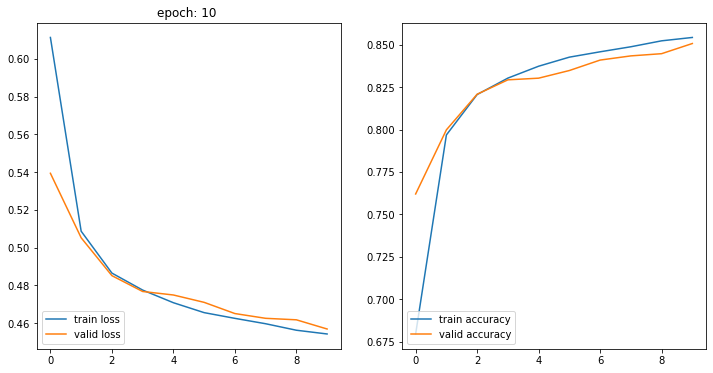

train loss:  0.4542025586313825
valid loss:  0.4568389004500455
train accuracy:  0.8542318940162659
valid accuracy:  0.8506683111190796
best metric epoch : 9, best metric accuracy : 0.8506683111190796
1 epoch time : 80.15808620850245 min


2595it [1:12:08,  1.67s/it]
<ipython-input-8-012b4a5e8e94>:45: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accs_train = np.append(accs_train,correct.cpu()/np.float(len(trainset))) # loss_train array에 해당 epoch의 평균 accuracy값 추가??print('2')
0it [00:00, ?it/s]

2


378it [07:45,  1.23s/it]
<ipython-input-8-012b4a5e8e94>:65: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accs_valid = np.append(accs_valid,correct.cpu()/np.float(len(validset))) # loss_train array에 해당 epoch의 평균 accuracy값 추가??
<ipython-input-8-012b4a5e8e94>:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (correct.cpu()/np.float(len(v

3
saved new best metric model


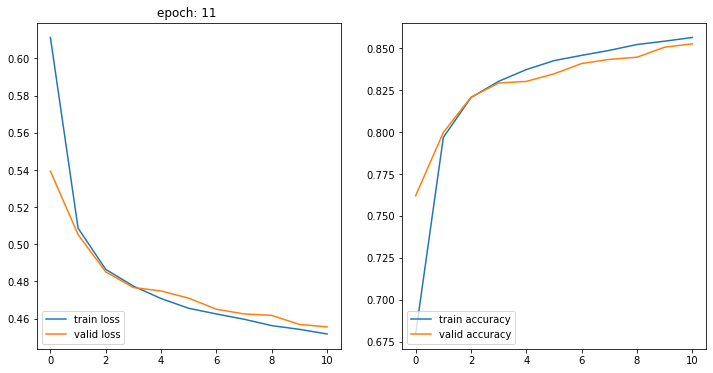

0it [00:00, ?it/s]

train loss:  0.45170216349048653
valid loss:  0.45553330517319773
train accuracy:  0.8564634323120117
valid accuracy:  0.8526572585105896
best metric epoch : 10, best metric accuracy : 0.8526572585105896
1 epoch time : 79.92344975471497 min


2595it [1:13:32,  1.70s/it]
<ipython-input-8-012b4a5e8e94>:45: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accs_train = np.append(accs_train,correct.cpu()/np.float(len(trainset))) # loss_train array에 해당 epoch의 평균 accuracy값 추가??print('2')
0it [00:00, ?it/s]

2


378it [07:52,  1.25s/it]
<ipython-input-8-012b4a5e8e94>:65: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accs_valid = np.append(accs_valid,correct.cpu()/np.float(len(validset))) # loss_train array에 해당 epoch의 평균 accuracy값 추가??
<ipython-input-8-012b4a5e8e94>:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (correct.cpu()/np.float(len(v

3
saved new best metric model


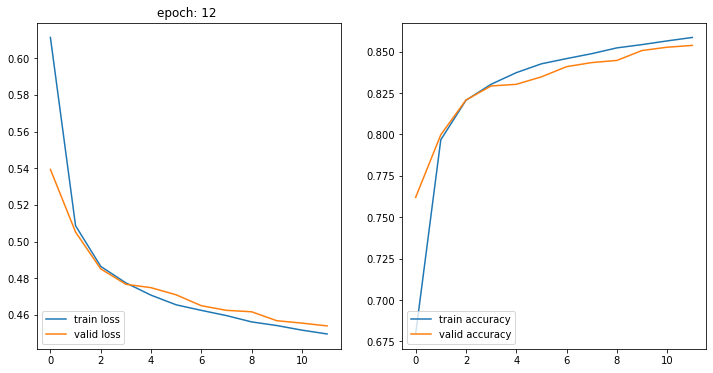

train loss:  0.4496072581737717
valid loss:  0.454010009765625
train accuracy:  0.8585408329963684
valid accuracy:  0.8537445664405823
best metric epoch : 11, best metric accuracy : 0.8537445664405823
1 epoch time : 81.43675804932913 min


2595it [1:13:17,  1.69s/it]
<ipython-input-8-012b4a5e8e94>:45: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accs_train = np.append(accs_train,correct.cpu()/np.float(len(trainset))) # loss_train array에 해당 epoch의 평균 accuracy값 추가??print('2')
0it [00:00, ?it/s]

2


378it [07:52,  1.25s/it]
<ipython-input-8-012b4a5e8e94>:65: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accs_valid = np.append(accs_valid,correct.cpu()/np.float(len(validset))) # loss_train array에 해당 epoch의 평균 accuracy값 추가??
<ipython-input-8-012b4a5e8e94>:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (correct.cpu()/np.float(len(v

3
saved new best metric model


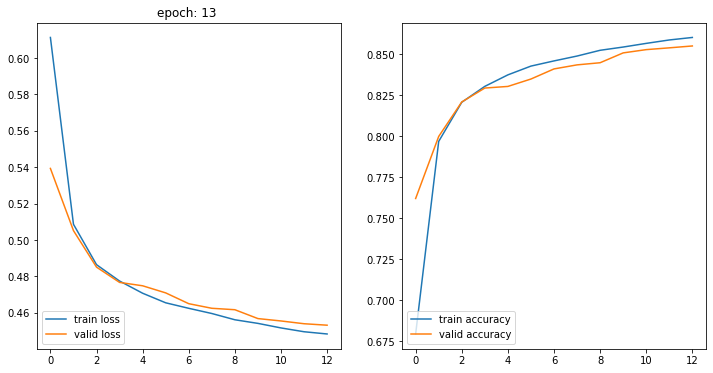

0it [00:00, ?it/s]

train loss:  0.4483822273151493
valid loss:  0.45320460405299273
train accuracy:  0.8600631952285767
valid accuracy:  0.854884922504425
best metric epoch : 12, best metric accuracy : 0.854884922504425
1 epoch time : 81.18754840691885 min


2595it [1:12:57,  1.69s/it]
<ipython-input-8-012b4a5e8e94>:45: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accs_train = np.append(accs_train,correct.cpu()/np.float(len(trainset))) # loss_train array에 해당 epoch의 평균 accuracy값 추가??print('2')
0it [00:00, ?it/s]

2


378it [07:47,  1.24s/it]
<ipython-input-8-012b4a5e8e94>:65: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accs_valid = np.append(accs_valid,correct.cpu()/np.float(len(validset))) # loss_train array에 해당 epoch의 평균 accuracy값 추가??
<ipython-input-8-012b4a5e8e94>:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (correct.cpu()/np.float(len(v

3
saved new best metric model


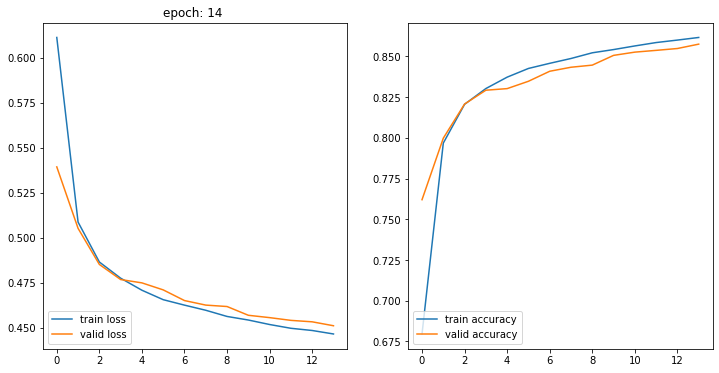

0it [00:00, ?it/s]

train loss:  0.44644594284381023
valid loss:  0.4510244541067295
train accuracy:  0.8616665601730347
valid accuracy:  0.8575633764266968
best metric epoch : 13, best metric accuracy : 0.8575633764266968
1 epoch time : 80.77572632233301 min


2595it [1:11:17,  1.65s/it]
<ipython-input-8-012b4a5e8e94>:45: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accs_train = np.append(accs_train,correct.cpu()/np.float(len(trainset))) # loss_train array에 해당 epoch의 평균 accuracy값 추가??print('2')
0it [00:00, ?it/s]

2


378it [07:33,  1.20s/it]
<ipython-input-8-012b4a5e8e94>:65: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accs_valid = np.append(accs_valid,correct.cpu()/np.float(len(validset))) # loss_train array에 해당 epoch의 평균 accuracy값 추가??
<ipython-input-8-012b4a5e8e94>:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (correct.cpu()/np.float(len(v

3


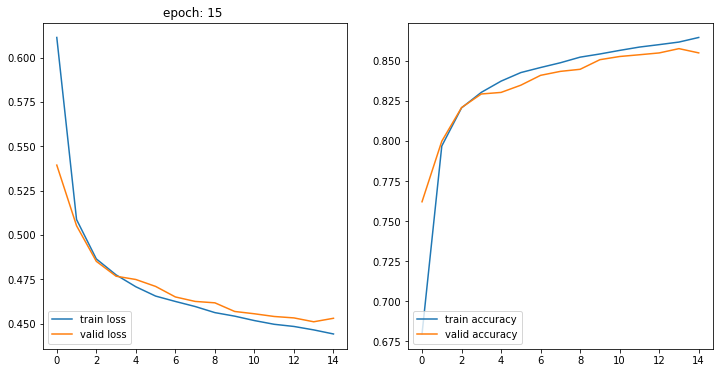

train loss:  0.44414749292509637
valid loss:  0.4529959058004712
train accuracy:  0.8645340204238892
valid accuracy:  0.8549114465713501
best metric epoch : 13, best metric accuracy : 0.8575633764266968
1 epoch time : 78.86721569697062 min


477it [12:46,  1.60s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

2595it [1:16:00,  1.76s/it]
<ipython-input-8-012b4a5e8e94>:45: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accs_train = np.append(accs_train,correct.cpu()/np.float(len(trainset))) # loss_train array에 해당 epoch의 평균 accuracy값 추가??print('2')
0it [00:00, ?it/s]

2


378it [07:27,  1.18s/it]
<ipython-input-8-012b4a5e8e94>:65: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accs_valid = np.append(accs_valid,correct.cpu()/np.float(len(validset))) # loss_train array에 해당 epoch의 평균 accuracy값 추가??
<ipython-input-8-012b4a5e8e94>:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (correct.cpu()/np.float(len(v

3


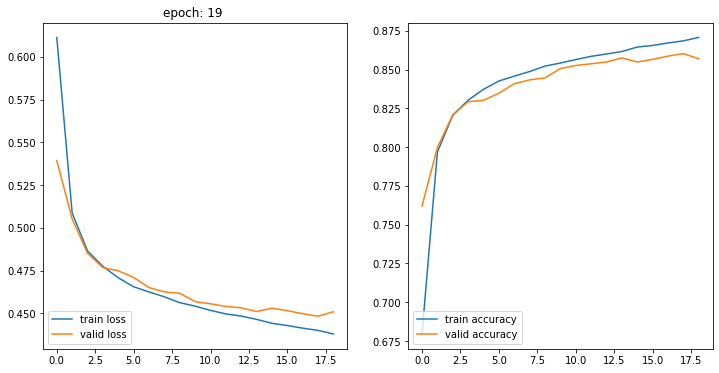

train loss:  0.43790102096881023
valid loss:  0.45088607545882936
train accuracy:  0.8707237839698792
valid accuracy:  0.8569799661636353
best metric epoch : 17, best metric accuracy : 0.8603214025497437
1 epoch time : 83.50106072028478 min


2166it [59:45,  1.70s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

2595it [1:27:22,  2.02s/it]
<ipython-input-8-012b4a5e8e94>:45: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accs_train = np.append(accs_train,correct.cpu()/np.float(len(trainset))) # loss_train array에 해당 epoch의 평균 accuracy값 추가??print('2')
0it [00:00, ?it/s]

2


378it [10:02,  1.59s/it]
<ipython-input-8-012b4a5e8e94>:65: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accs_valid = np.append(accs_valid,correct.cpu()/np.float(len(validset))) # loss_train array에 해당 epoch의 평균 accuracy값 추가??
<ipython-input-8-012b4a5e8e94>:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (correct.cpu()/np.float(len(v

3
saved new best metric model


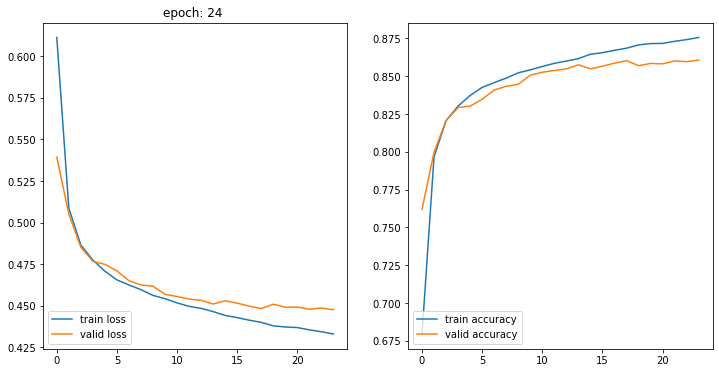

0it [00:00, ?it/s]

train loss:  0.43300339068521193
valid loss:  0.4475787531131159
train accuracy:  0.8756455779075623
valid accuracy:  0.8606926798820496
best metric epoch : 23, best metric accuracy : 0.8606926798820496
1 epoch time : 97.44077175458273 min


1121it [37:41,  1.81s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

378it [07:07,  1.13s/it]
<ipython-input-8-012b4a5e8e94>:65: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accs_valid = np.append(accs_valid,correct.cpu()/np.float(len(validset))) # loss_train array에 해당 epoch의 평균 accuracy값 추가??
<ipython-input-8-012b4a5e8e94>:68: DeprecationWarning: `np.float` is a deprecated alias for t

3


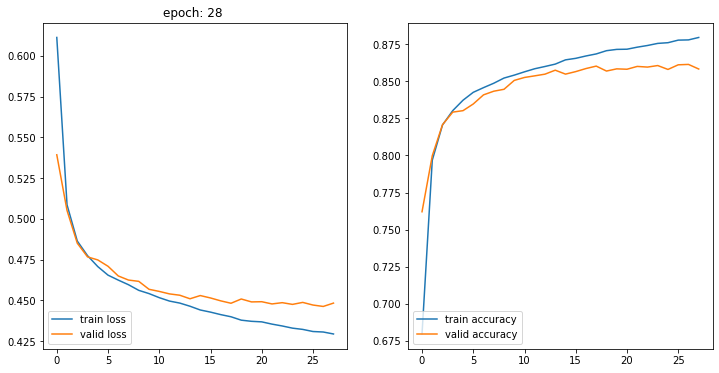

train loss:  0.42942967056539016
valid loss:  0.4483651458901703
train accuracy:  0.8796500563621521
valid accuracy:  0.8583589792251587
best metric epoch : 26, best metric accuracy : 0.8614617586135864
1 epoch time : 78.00153224468231 min


2595it [1:12:05,  1.67s/it]
<ipython-input-8-012b4a5e8e94>:45: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accs_train = np.append(accs_train,correct.cpu()/np.float(len(trainset))) # loss_train array에 해당 epoch의 평균 accuracy값 추가??print('2')
0it [00:00, ?it/s]

2


198it [03:45,  1.14s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

2595it [1:12:35,  1.68s/it]
<ipython-input-8-012b4a5e8e94>:45: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accs_train = np.append(accs_train,correct.cpu()/np.float(len(trainset))) # loss_train array에 해당 epoch의 평균 accuracy값 추가??print('2')
0it [00:00, ?it/s]

2


378it [07:11,  1.14s/it]
<ipython-input-8-012b4a5e8e94>:65: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accs_valid = np.append(accs_valid,correct.cpu()/np.float(len(validset))) # loss_train array에 해당 epoch의 평균 accuracy값 추가??
<ipython-input-8-012b4a5e8e94>:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (correct.cpu()/np.float(len(v

3
saved new best metric model


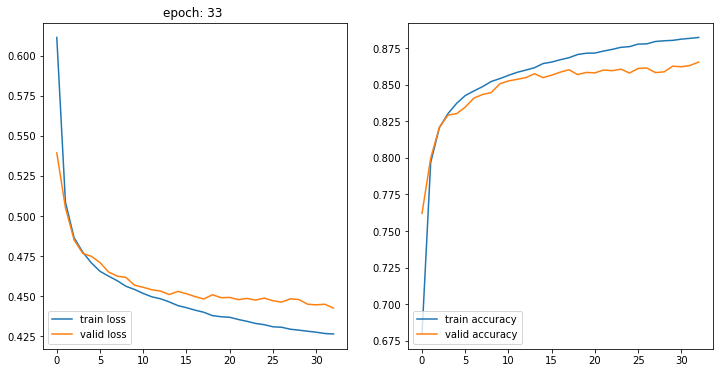

train loss:  0.42645040229106457
valid loss:  0.44258113639064567
train accuracy:  0.8823865056037903
valid accuracy:  0.8655722737312317
best metric epoch : 32, best metric accuracy : 0.8655722737312317
1 epoch time : 79.80321131149928 min


1744it [47:25,  2.08s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

2595it [1:20:10,  1.85s/it]
<ipython-input-8-012b4a5e8e94>:45: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accs_train = np.append(accs_train,correct.cpu()/np.float(len(trainset))) # loss_train array에 해당 epoch의 평균 accuracy값 추가??print('2')
0it [00:00, ?it/s]

2


378it [08:00,  1.27s/it]
<ipython-input-8-012b4a5e8e94>:65: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accs_valid = np.append(accs_valid,correct.cpu()/np.float(len(validset))) # loss_train array에 해당 epoch의 평균 accuracy값 추가??
<ipython-input-8-012b4a5e8e94>:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (correct.cpu()/np.float(len(v

3


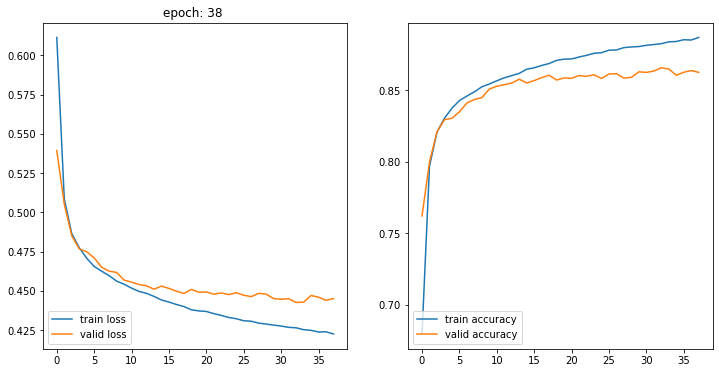

train loss:  0.42251837405166187
valid loss:  0.4450509611260954
train accuracy:  0.8867378234863281
valid accuracy:  0.8623633980751038
best metric epoch : 32, best metric accuracy : 0.8655722737312317
1 epoch time : 88.21539493004481 min


631it [17:32,  1.64s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

2595it [1:30:49,  2.10s/it]
<ipython-input-8-012b4a5e8e94>:45: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accs_train = np.append(accs_train,correct.cpu()/np.float(len(trainset))) # loss_train array에 해당 epoch의 평균 accuracy값 추가??print('2')
0it [00:00, ?it/s]

2


378it [09:22,  1.49s/it]
<ipython-input-8-012b4a5e8e94>:65: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accs_valid = np.append(accs_valid,correct.cpu()/np.float(len(validset))) # loss_train array에 해당 epoch의 평균 accuracy값 추가??
<ipython-input-8-012b4a5e8e94>:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (correct.cpu()/np.float(len(v

3


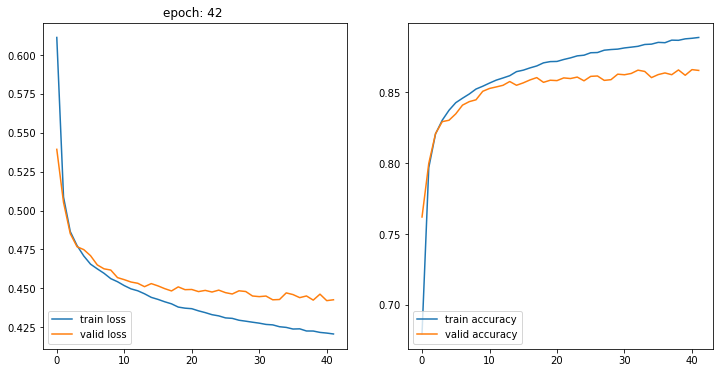

train loss:  0.42059831858140656
valid loss:  0.4425922777286913
train accuracy:  0.8886263966560364
valid accuracy:  0.8653866648674011
best metric epoch : 40, best metric accuracy : 0.8659435510635376
1 epoch time : 100.22506438493728 min


2153it [1:05:04,  1.72s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

2595it [1:14:05,  1.71s/it]
<ipython-input-8-012b4a5e8e94>:45: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accs_train = np.append(accs_train,correct.cpu()/np.float(len(trainset))) # loss_train array에 해당 epoch의 평균 accuracy값 추가??print('2')
0it [00:00, ?it/s]

2


378it [07:10,  1.14s/it]
<ipython-input-8-012b4a5e8e94>:65: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accs_valid = np.append(accs_valid,correct.cpu()/np.float(len(validset))) # loss_train array에 해당 epoch의 평균 accuracy값 추가??
<ipython-input-8-012b4a5e8e94>:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (correct.cpu()/np.float(len(v

3


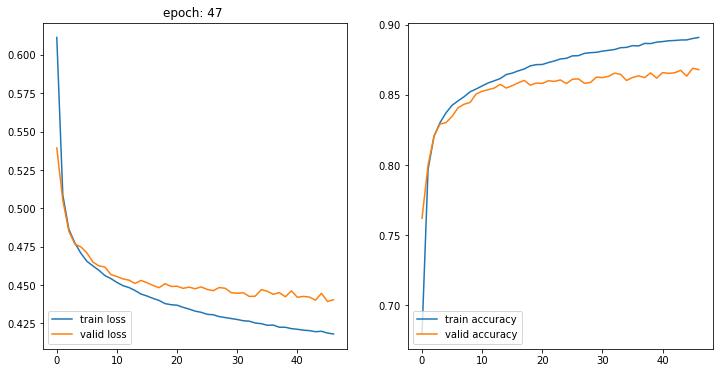

train loss:  0.41811927986512526
valid loss:  0.44041802138878555
train accuracy:  0.8909851312637329
valid accuracy:  0.8680385947227478
best metric epoch : 45, best metric accuracy : 0.8690463304519653
1 epoch time : 81.29146383603414 min


2489it [1:09:47,  1.86s/it]

In [ ]:

# In[ ]:


#if resume: #resume 이 True면 학습된 모델의 parameter 불러오기
#    net.load_state_dict(torch.load(f'Y:\\hsyoo\\pth\\pth_80\\level_{level}\\best_model_level{level}.pth'))
    # 기존의 parameter 업로드 없이 진행
    
loss_train = np.array([])  # train loss 값들을 저장할 numpy array 생성
loss_valid = np.array([])  # vlaid loss 값들을 저장할 numpy array 생성
accs_train = np.array([])  # train accuracy 값들을 저장할 numpy array 생성
accs_valid = np.array([])  # valid accuracy 값들을 저장할 numpy array 생성
best_metric = -1           # 왜 -1 ??? >>초기값 세팅 업데이트할 때 
best_metric_epoch = -1     # ???? >>초기값 세팅

for epoch in range(num_epochs): # 설정한 epoch만큼 반복
    stime = time.time() # 시작 시간 ???
    net.train() # 모델을 train을 하기위한 상태로 바꾸기
    i=0  
    l_epoch = 0  # 해당 epoch의 평균 loss 값??
    correct = 0  # 모델이 맞춘 개수?
    l_epoch_val = 0  # 해당 epoch의 ???
#    print('1')
#    print(train_loader)
    for batch_idx, item in tqdm(enumerate(train_loader)): # train loder에서 하나씩 데이터를 불러오기
#    One_batch = next(iter(train_loader))
#    for item in tqdm(next(iter(train_loader))): # train loder에서 하나씩 데이터를 불러오기
        i=i+1 #한 번 돌때마다 i 값 1씩 증가
        
#        print("vvvvvvv")
#        print(item)
#        print(type(item))
#        print("vvvvvvv")
        
        image, y = item['image'].to(device), item['label'].type(torch.long).to(device) #image와 label에 GPU버전에 맞춰서 설정
        y_hat=net(image) # 예측값
        y_hat= F.softmax(y_hat, dim = 1) # 예측값에 soft max 적용
        l=loss(y_hat,y)  # loss 값 저장
        correct += (y_hat.argmax(dim=1)==y).sum() # y_hat과 label이 같은 것들의 합???? 
        l_epoch+=l # loss 값들 더해줌
        #Pytorch에서는 gradients값들을 추후에 backward를 해줄때 계속 더해주기 때문"에 우리는 항상 backpropagation을 하기전에 gradients를 zero로 만들어주고 시작을 해야합니다
        alg.zero_grad()
        l.backward() # 현재 tensor의 gradient를 계산
        alg.step() # ??? 찾아보기 ***************** ( optimize.step())
    loss_train = np.append(loss_train,l_epoch.cpu().detach().numpy()/i) # loss_train array에 해당 epoch의 평균 loss값 추가??
    accs_train = np.append(accs_train,correct.cpu()/np.float(len(trainset))) # loss_train array에 해당 epoch의 평균 accuracy값 추가??print('2')
    
    print('2')
    correct = 0 # correct값 초기화?
    i = 0   # i값 초기화
    net.eval() # #모델을 evaluation mode로 설정(계산에 필요한 메모리 소모량을 줄일 수 있음)
    with torch.no_grad(): # gradinet 계산하지 않음
        for batch_idx,item in tqdm(enumerate(valid_loader)): # valid set data들을 하나씩 가져옴
            i +=1
            
#            print("vvvvvvv")            
#            print(type(item))
#            print("vvvvvvv")
            
            image, y = item['image'].to(device), item['label'].to(device)
            y_hat=net(image)
            y_hat= F.softmax(y_hat, dim = 1)
            l = loss(y_hat, y)
            correct += (y_hat.argmax(dim=1)==y).sum()
            l_epoch_val += l
    accs_valid = np.append(accs_valid,correct.cpu()/np.float(len(validset))) # loss_train array에 해당 epoch의 평균 accuracy값 추가??
    loss_valid = np.append(loss_valid, l_epoch_val.cpu().detach().numpy()/i) # loss_train array에 해당 epoch의 평균 loss값 추가??
    print('3')
    if (correct.cpu()/np.float(len(validset))) > best_metric:  # best metric 보다 accuracy가 좋다면?? #현재 result가 가장 좋다면 best_metric으로 저장
        best_metric = correct.cpu()/np.float(len(validset))    # 현재 parameter를 best_metric에 저장?
        best_metric_epoch = epoch                              # 가장 결과가 좋았던 epoch을 저장??
        # 지정해준 PATH에 최상의 결과에 대한 모델 weight를 파일에 저장
        torch.save(net.state_dict(), f"Y:\\mhson\\pth\\pth_80\\level_{level}\\best_model_level{level}.pth")
        print("saved new best metric model") 
    
#     torch.save(net.state_dict(), f'Y:\data\patch\mhson\level_{level}\eff_b0_pth_{epoch}.pth')
    
    if True: # 무조건 실행 지워도 상관x
        # 각 epoch에 대한 train loss 와 vaild loss 출력
        fig = plt.figure(figsize = (12, 6))
        ax = fig.add_subplot(1,2,1)
        plt.plot(loss_train,label='train loss')
        plt.plot(loss_valid, label='valid loss')
        plt.legend(loc='lower left')
        plt.title('epoch: %d '%(epoch+1))
        
        # 각 epoch에 대한 train accuracy 와 vaild accuracy 출력 및 저장
        ax = fig.add_subplot(1,2,2)
        plt.plot(accs_train,label='train accuracy')
        plt.plot(accs_valid,label='valid accuracy')
        plt.legend(loc='lower left')
        plt.pause(.0001)
        plt.show()
        fig.savefig(f"Y:\\mhson\\result\\loss\\loss_80\\level_{level}\\eff_b0_step1_cla_loss.png")

 ########## 코드에 save가 적혀있으면 경로 mhson으로 수정하고 진행하기!!
        
        # 가장 마지막 loss와 accuracy를 출력하고 best metric에 대한 accuracy , epoch당 소요된 시간 출력??
        print('train loss: ',loss_train[-1])
        print('valid loss: ', loss_valid[-1])
        print('train accuracy: ',accs_train[-1])
        print('valid accuracy: ',accs_valid[-1])
        print(f"best metric epoch : {best_metric_epoch}, best metric accuracy : {best_metric}")
    print(f"1 epoch time : {(time.time() - stime) / 60} min")
    
    
    

공부할 것

1.num_worker와 window

2.alg.step()

3. train과 vaild 각각 몇 명의 데이터를 사용하였고 patch 크기, 개수 level 다 언급